In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [2]:
activity_ids = {
    0:"other (transient activities)",
    1 :"lying",
    2 :"sitting",
    3 :"standing",
    4 :"walking",
    5 :"running",
    6 :"cycling",
    7 :"Nordic walking",
    9 :"watching TV",
    10:"computer work",
    11:"car driving",
    12:"ascending stairs",
    13:"descending stairs",
    16:"vacuum cleaning",
    17:"ironing",
    18:"folding laundry",
    19:"house cleaning",
    20:"playing soccer",
    24:"rope jumping",
    }


In [3]:
def generate_cols():
    imu_cols= []
    cols = ["t_stamp", "Activity ID", "Heart Rate"]
    
    for i in ['Hand', "Chest", "Anckle"]:
        c = [
            f"IMU {i} Temperature", 
            f"IMU {i} Acc X1", f"IMU {i} Acc Y1", f"IMU {i} Acc Z1", 
            f"IMU {i} Acc X2", f"IMU {i} Acc Y2", f"IMU {i} Acc Z2", 
            f"IMU {i} Gyr X", f"IMU {i} Gyr Y", f"IMU {i} Gyr Z", 
            f"IMU {i} Mag X", f"IMU {i} Mag Y", f"IMU {i} Mag Z",
            f"invalid", f"invalid", f"invalid", "invalid"]
        imu_cols.extend(c)
        
    cols.extend(imu_cols)
    return cols


def load_subject(filename:str): 
    df_s = pd.read_csv(filename, delimiter=" ")
    df_s.columns = generate_cols()
    
    df_s = df_s.drop(columns=["invalid"])
    df_s = df_s.set_index(["t_stamp"])
    df_s = df_s.ffill()
    df_s = df_s.rename(columns={"Activity ID":"labels"})
    
    # df_s["Heart Rate"] = df_s["Heart Rate"].ffill()
    
    return df_s

In [4]:
def get_activity(df_subject:pd.DataFrame, activity_id:int, cols:list):
    return df_subject[df_subject["labels"] == activity_id][cols]

In [5]:
def get_activity_sequences(df:pd.DataFrame, activity_id:int, sequence_duration:float, cols:list):
    n_sequence = sequence_duration* 100
    sequence= df[df["labels"] == activity_id][cols].values
    
    curr = 0
    overlap= 0.1
    sequences= []
    
    while curr+ n_sequence < sequence.shape[0]:
        seq = sequence[curr: curr+n_sequence]
        
        if np.sum(np.isnan(seq)) == 0:
            sequences.append(seq)
        curr = int(curr + n_sequence* overlap)
        
        
    return np.array(sequences)

In [6]:
from sklearn.decomposition import PCA
def reduce_dim(subject_sequences:list):
    
    _all_sequences = np.concatenate(subject_sequences)
    
    _subject_sequences = _all_sequences.reshape((-1, _all_sequences.shape[-2]* _all_sequences.shape[-1]))
        
    reducer = PCA()
    reducer = reducer.fit(_subject_sequences)

    return [reducer.transform(subject_sequence.reshape((-1, subject_sequence.shape[-2]* subject_sequence.shape[-1]))) for subject_sequence in subject_sequences]

In [7]:
def plot_activity(df_subject:pd.DataFrame, activity_id:int, t_window:float=60.):
    ax_cols = [
        ['IMU Hand Acc X1','IMU Hand Acc Y1', 'IMU Hand Acc Z1'],
        ['IMU Chest Acc X2','IMU Chest Acc Y2', 'IMU Chest Acc Z2'],
        ['IMU Anckle Acc X2','IMU Anckle Acc Y2', 'IMU Anckle Acc Z2']
        ]
    
    n_suplot = len(ax_cols)

    start = df_subject[df_subject["labels"] == activity_id].index[0]

    plt.figure(figsize=(13, 7))
    plt.suptitle(activity_ids[activity_id])
    for i, cs in enumerate(ax_cols):
        ax = plt.subplot(n_suplot, 1, i+1)
        df_subject.loc[start: start+ t_window][cs].plot(ax=ax)
        df_subject.loc[start: start+ t_window]["Heart Rate"].plot(ax=ax)
        ax.grid(True)
        
    plt.tight_layout()
    plt.show()

In [8]:

def normalized_datasets(dataframe:pd.DataFrame, scaler:StandardScaler):
    labels_values = dataframe['labels'].values    
    
    normalized_values = scaler.transform(dataframe.values)

    _dset =  pd.DataFrame(data=normalized_values, columns=dataframe.columns, index=dataframe.index)
    _dset['labels'] = labels_values
    return _dset

def normalize_datasets(datasets:tuple):
    dsets = pd.concat(datasets)
    
    _dset_values = dsets.values
    
    scaler = StandardScaler()
    scaler.fit(_dset_values)
    
    normalized_dsets = [normalized_datasets(d, scaler) for d in datasets]
    
    return normalized_dsets

In [9]:
SUBJECT_FOLDER = "data/PAMAP2"

df_s1 = load_subject(f"{SUBJECT_FOLDER}/subject101.dat")
df_s5 = load_subject(f"{SUBJECT_FOLDER}/subject105.dat")
df_s6 = load_subject(f"{SUBJECT_FOLDER}/subject106.dat")
df_s8 = load_subject(f"{SUBJECT_FOLDER}/subject108.dat")

(df_s1, df_s5, df_s6, df_s8) = normalize_datasets(((df_s1, df_s5, df_s6, df_s8)))

In [10]:
def make_train_valid_split(dataset:pd.DataFrame, labels:list, train_split:float=0.8):
    train_datasets, valid_datasets = [], []
    
    for l in labels:
        datasset_part = dataset[dataset["labels"] == l].values
        shape = datasset_part.shape
        
        train_end = int(shape[0]*train_split)
        
        train_part = datasset_part[:train_end]
        valid_part = datasset_part[train_end:]
        
        train_datasets.append(train_part)
        valid_datasets.append(valid_part)
        
    train_datasets = np.concatenate(train_datasets)
    valid_datasets = np.concatenate(valid_datasets)
    
    train_datasets = pd.DataFrame(data=train_datasets, columns=dataset.columns)
    valid_datasets = pd.DataFrame(data=valid_datasets, columns=dataset.columns)
    
    return train_datasets, valid_datasets

In [11]:
cols = ["Heart Rate", 'IMU Hand Acc X1', 'IMU Hand Acc Y1', 'IMU Hand Acc Z1',  'IMU Chest Acc X1', 'IMU Chest Acc Y1', 'IMU Chest Acc Z1', 'IMU Anckle Acc X1', 'IMU Anckle Acc Y1', 'IMU Anckle Acc Z1', "labels"]
cols = ["Heart Rate", 'IMU Hand Acc X1', 'IMU Hand Acc Y1', 'IMU Hand Acc Z1',  'IMU Anckle Acc X1', 'IMU Anckle Acc Y1', 'IMU Anckle Acc Z1', "labels"]

reshaped_cols = [["Heart Rate", 'IMU Hand Acc X1', 'IMU Hand Acc Y1', 'IMU Hand Acc Z1'],  
        ['IMU Chest Acc X1', 'IMU Chest Acc Y1', 'IMU Chest Acc Z1'], 
        ['IMU Anckle Acc X1', 'IMU Anckle Acc Y1', 'IMU Anckle Acc Z1']]

labels = [4,5,12,13,24]

In [12]:
dfs1_train, dfs1_valid = make_train_valid_split(df_s1, labels)
dfs5_train, dfs5_valid = make_train_valid_split(df_s5, labels)
dfs6_train, dfs6_valid = make_train_valid_split(df_s6, labels)
dfs8_train, dfs8_valid = make_train_valid_split(df_s8, labels)

In [13]:
dfs1_train[cols].to_hdf(f"{SUBJECT_FOLDER}/subject101_train.h5", key="data")
dfs1_valid[cols].to_hdf(f"{SUBJECT_FOLDER}/subject101_valid.h5", key="data")

dfs5_train[cols].to_hdf(f"{SUBJECT_FOLDER}/subject105_train.h5", key="data")
dfs5_valid[cols].to_hdf(f"{SUBJECT_FOLDER}/subject105_valid.h5", key="data")

dfs6_train[cols].to_hdf(f"{SUBJECT_FOLDER}/subject106_train.h5", key="data")
dfs6_valid[cols].to_hdf(f"{SUBJECT_FOLDER}/subject106_valid.h5", key="data")

dfs8_train[cols].to_hdf(f"{SUBJECT_FOLDER}/subject108_train.h5", key="data")
dfs8_valid[cols].to_hdf(f"{SUBJECT_FOLDER}/subject108_valid.h5", key="data")

## Walking !

In [14]:
subject_activity = [get_activity(df_s1, 4, cols), get_activity(df_s5, 4, cols), get_activity(df_s6, 4, cols), get_activity(df_s8, 4, cols)]

In [15]:
def compare_walking(col:str):
    first_start = 2254
    second_start = 2239.66
    third_start = 2315.35
    fourth_start = 2264.04

    wl = 8
    plt.figure(figsize=(18, 7))
    plt.suptitle(f'Comparison between subjects \nSensor \"{col}\"')
    
    plt.subplot(311)
    plt.plot(subject_activity[0].loc[first_start:first_start+wl][col].values, label="subject 1")
    plt.plot(subject_activity[1].loc[second_start:second_start+wl][col].values, label="subject 2")

    plt.legend()
    plt.grid()


    plt.subplot(312)
    plt.plot(subject_activity[0].loc[first_start:first_start+wl][col].values, label="subject 1")
    plt.plot(subject_activity[2].loc[third_start:third_start+wl][col].values, label="subject 3")

    plt.legend()
    plt.grid()


    plt.subplot(313)
    plt.plot(subject_activity[0].loc[first_start:first_start+wl][col].values, label="subject 1")
    plt.plot(subject_activity[3].loc[fourth_start:fourth_start+wl][col].values, label="subject 4")


    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    

In [16]:
cols

['Heart Rate',
 'IMU Hand Acc X1',
 'IMU Hand Acc Y1',
 'IMU Hand Acc Z1',
 'IMU Anckle Acc X1',
 'IMU Anckle Acc Y1',
 'IMU Anckle Acc Z1',
 'labels']

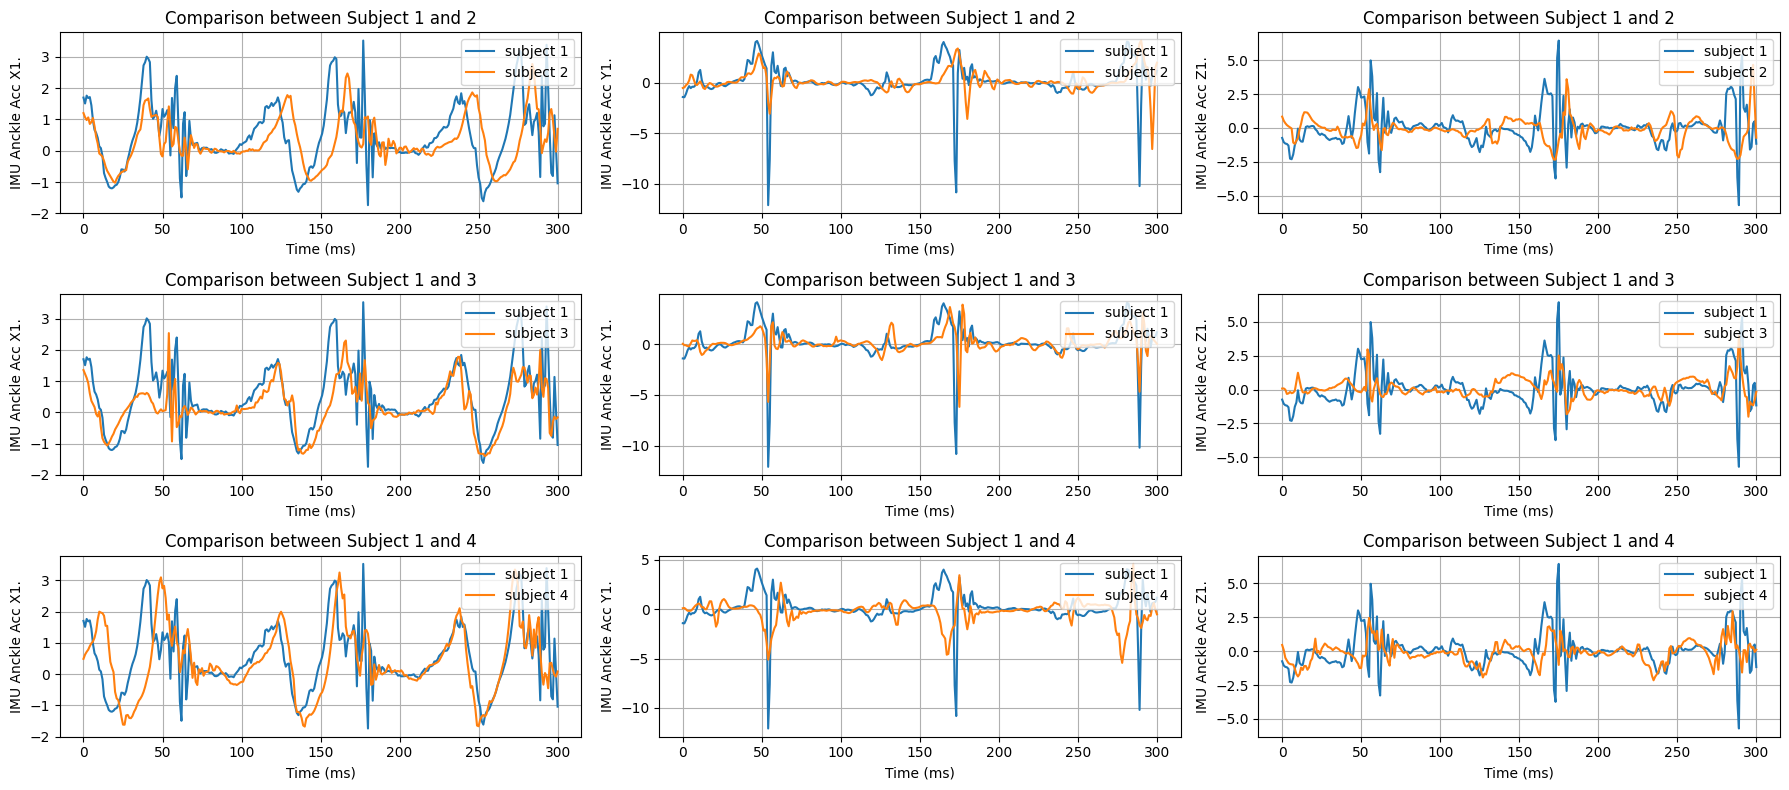

In [21]:
# Make Paper figure for comparison. 

first_start = 2254
second_start = 2239.66
third_start = 2315.35
fourth_start = 2264.04

wl = 3


plt.figure(figsize=(18, 8))

ax = plt.subplot(3, 3, 1)
ax.set_title('Comparison between Subject 1 and 2')
ax.grid(True)

plt.plot(subject_activity[0].loc[first_start:first_start+wl]["IMU Anckle Acc X1"].values, label="subject 1")
plt.plot(subject_activity[1].loc[second_start:second_start+wl]["IMU Anckle Acc X1"].values, label="subject 2")
ax.legend(loc=1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('IMU Anckle Acc X1.')


ax = plt.subplot(3, 3, 2)
ax.grid(True)
ax.set_title('Comparison between Subject 1 and 2')

plt.plot(subject_activity[0].loc[first_start:first_start+wl]["IMU Anckle Acc Y1"].values, label="subject 1")
plt.plot(subject_activity[1].loc[second_start:second_start+wl]["IMU Anckle Acc Y1"].values, label="subject 2")
ax.legend(loc=1)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('IMU Anckle Acc Y1.')



ax = plt.subplot(3, 3, 3)
ax.grid(True)
ax.set_title('Comparison between Subject 1 and 2')

plt.plot(subject_activity[0].loc[first_start:first_start+wl]["IMU Anckle Acc Z1"].values, label="subject 1")
plt.plot(subject_activity[1].loc[second_start:second_start+wl]["IMU Anckle Acc Z1"].values, label="subject 2")
ax.legend(loc=1)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('IMU Anckle Acc Z1.')




##### 
# Subject 3
#####

ax = plt.subplot(3, 3, 4)
ax.set_title('Comparison between Subject 1 and 3')
ax.grid(True)

plt.plot(subject_activity[0].loc[first_start:first_start+wl]["IMU Anckle Acc X1"].values, label="subject 1")
plt.plot(subject_activity[2].loc[third_start:third_start+wl]["IMU Anckle Acc X1"].values, label="subject 3")
ax.legend(loc=1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('IMU Anckle Acc X1.')



ax = plt.subplot(3, 3, 5)
ax.grid(True)
ax.set_title('Comparison between Subject 1 and 3')

plt.plot(subject_activity[0].loc[first_start:first_start+wl]["IMU Anckle Acc Y1"].values, label="subject 1")
plt.plot(subject_activity[2].loc[third_start:third_start+wl]["IMU Anckle Acc Y1"].values, label="subject 3")
ax.legend(loc=1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('IMU Anckle Acc Y1.')



ax = plt.subplot(3, 3, 6)
ax.grid(True)
ax.set_title('Comparison between Subject 1 and 3')

plt.plot(subject_activity[0].loc[first_start:first_start+wl]["IMU Anckle Acc Z1"].values, label="subject 1")
plt.plot(subject_activity[2].loc[third_start:third_start+wl]["IMU Anckle Acc Z1"].values, label="subject 3")
ax.legend(loc=1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('IMU Anckle Acc Z1.')



##### 
# Subject 4
#####

ax = plt.subplot(3, 3, 7)
ax.set_title('Comparison between Subject 1 and 4')
ax.grid(True)

plt.plot(subject_activity[0].loc[first_start:first_start+wl]["IMU Anckle Acc X1"].values, label="subject 1")
plt.plot(subject_activity[3].loc[fourth_start:fourth_start+wl]["IMU Anckle Acc X1"].values, label="subject 4")
ax.legend(loc=1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('IMU Anckle Acc X1.')



ax = plt.subplot(3, 3, 8)
ax.grid(True)
ax.set_title('Comparison between Subject 1 and 4')

plt.plot(subject_activity[0].loc[first_start:first_start+wl]["IMU Anckle Acc Y1"].values, label="subject 1")
plt.plot(subject_activity[3].loc[fourth_start:fourth_start+wl]["IMU Anckle Acc Y1"].values, label="subject 4")
ax.legend(loc=1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('IMU Anckle Acc Y1.')



ax = plt.subplot(3, 3, 9)
ax.grid(True)
ax.set_title('Comparison between Subject 1 and 4')

plt.plot(subject_activity[0].loc[first_start:first_start+wl]["IMU Anckle Acc Z1"].values, label="subject 1")
plt.plot(subject_activity[3].loc[fourth_start:fourth_start+wl]["IMU Anckle Acc Z1"].values, label="subject 4")
ax.legend(loc=1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('IMU Anckle Acc Z1.')


plt.tight_layout()

plt.savefig('imgs/HAR_Example.pdf')

In [26]:
subject_activity_running = [get_activity(df_s1, 5, cols), get_activity(df_s5, 5, cols), get_activity(df_s6, 5, cols), get_activity(df_s8, 5, cols)]


In [ ]:
# Make Paper figure for comparison. 

first_start_walk = 2254
fourth_start_walk = 2264.04

first_start_run = 3146
fourth_start_run = 3472.43

wl = 3


plt.figure(figsize=(18, 8))

ax = plt.subplot(2, 3, 1)
ax.set_title('Comparison between Subject 1 and 2\nIMU Anckle Acc X1.')
ax.grid(True)

plt.plot(subject_activity[0].loc[first_start_walk:first_start_walk+wl]["IMU Anckle Acc X1"].values, label="subject 1")
plt.plot(subject_activity[3].loc[fourth_start_walk:fourth_start_walk+wl]["IMU Anckle Acc X1"].values, label="subject 4")
ax.legend(loc=1)

ax = plt.subplot(2, 3, 2)
ax.grid(True)
ax.set_title('Comparison between Subject 1 and 2\nIMU Anckle Acc Y1.')

plt.plot(subject_activity[0].loc[first_start_walk:first_start_walk+wl]["IMU Anckle Acc Y1"].values, label="subject 1")
plt.plot(subject_activity[3].loc[fourth_start_walk:fourth_start_walk+wl]["IMU Anckle Acc Y1"].values, label="subject 4")
ax.legend(loc=1)

ax = plt.subplot(2, 3, 3)
ax.grid(True)
ax.set_title('Comparison between Subject 1 and 2\nIMU Anckle Acc Z1.')

plt.plot(subject_activity[0].loc[first_start_walk:first_start_walk+wl]["IMU Anckle Acc Z1"].values, label="subject 1")
plt.plot(subject_activity[3].loc[fourth_start_walk:fourth_start_walk+wl]["IMU Anckle Acc Z1"].values, label="subject 4")
ax.legend(loc=1)


# # ##### 
# # # Subject 4
# # #####

ax = plt.subplot(2, 3, 4)
ax.set_title('Comparison between Subject 1 and 4\nIMU Anckle Acc X1.')
ax.grid(True)

plt.plot(subject_activity_running[0].loc[first_start_run:first_start_run+wl]["IMU Anckle Acc X1"].values, label="subject 1")
plt.plot(subject_activity_running[3].loc[fourth_start_run:fourth_start_run+wl]["IMU Anckle Acc X1"].values, label="subject 4")

ax.legend(loc=1)

ax = plt.subplot(2, 3, 5)
ax.grid(True)
ax.set_title('Comparison between Subject 1 and 4\nIMU Anckle Acc Y1.')

plt.plot(subject_activity_running[0].loc[first_start_run:first_start_run+wl]["IMU Anckle Acc Y1"].values, label="subject 1")
plt.plot(subject_activity_running[3].loc[fourth_start_run:fourth_start_run+wl]["IMU Anckle Acc Y1"].values, label="subject 4")

ax.legend(loc=1)

ax = plt.subplot(2, 3, 6)
ax.grid(True)
ax.set_title('Comparison between Subject 1 and 4\nIMU Anckle Acc Z1.')

plt.plot(subject_activity_running[0].loc[first_start_run:first_start_run+wl]["IMU Anckle Acc Z1"].values, label="subject 1")
plt.plot(subject_activity_running[3].loc[fourth_start_run:fourth_start_run+wl]["IMU Anckle Acc Z1"].values, label="subject 4")

ax.legend(loc=1)



plt.tight_layout()

plt.savefig('imgs/HAR_Example2.pdf')

In [ ]:
for c in cols:
    compare_walking(c)

# Running !

In [16]:
subject_activity_running = [get_activity(df_s1, 5, cols), get_activity(df_s5, 5, cols), get_activity(df_s6, 5, cols), get_activity(df_s8, 5, cols)]


In [ ]:
subject_activity_running[3].head()

In [18]:
def compare_subject_on_running(col:str):
    first_start = 3146
    second_start = 3334.89
    third_start = 3291.14
    fourth_start = 3472.43

    wl = 8

    plt.figure(figsize=(18, 5))

    plt.suptitle(f"Comparison Between Subject on Running. \nSenssor \"{col}\"")

    plt.subplot(311)

    plt.plot(subject_activity_running[0].loc[first_start: first_start+ wl][col].values, label="Subject 1") 
    plt.plot(subject_activity_running[1].loc[second_start: second_start+ wl][col].values, label="Subject 2") 

    plt.grid()
    plt.legend()

    plt.subplot(312)
    plt.plot(subject_activity_running[0].loc[first_start: first_start+ wl][col].values, label="Subject 1") 
    plt.plot(subject_activity_running[2].loc[third_start: third_start+ wl][col].values, label="Subject 3") 

    plt.grid()
    plt.legend()

    plt.subplot(313)
    plt.plot(subject_activity_running[0].loc[first_start: first_start+ wl][col].values, label="Subject 1") 
    plt.plot(subject_activity_running[3].loc[fourth_start: fourth_start+ wl][col].values, label="Subject 4") 

    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
for c in cols:
    compare_subject_on_running(c)

# Asending Stairs

In [20]:
subject_activity_a_s = [get_activity(df_s1, 12, cols), get_activity(df_s5, 12, cols), get_activity(df_s6, 12, cols), get_activity(df_s8, 12, cols)]

In [ ]:
subject_activity_a_s[3]

In [22]:
def compare_ascending_stairs(col:str):
    first_start = 1558
    second_start = 1666.30

    third_start = 1663.42
    fourth_start = 1668.56
    wl = 10

    plt.figure(figsize=(18, 5))
    plt.suptitle(f"Comparison Between Subject on Running. \nSenssor \"{col}\"")

    plt.subplot(311)

    plt.plot(subject_activity_a_s[0].loc[first_start: first_start+ wl][col].values, label="subject 1")
    plt.plot(subject_activity_a_s[1].loc[second_start: second_start+ wl][col].values, label="subject 2")
    plt.grid()
    plt.legend()
    plt.subplot(312)
    plt.plot(subject_activity_a_s[0].loc[first_start: first_start+ wl][col].values, label="subject 1")
    plt.plot(subject_activity_a_s[2].loc[third_start: third_start+ wl][col].values, label="subject 3")
    plt.grid()
    plt.legend()


    plt.subplot(313)
    plt.plot(subject_activity_a_s[0].loc[first_start: first_start+ wl][col].values, label="subject 1")
    plt.plot(subject_activity_a_s[3].loc[fourth_start: fourth_start+ wl][col].values, label="subject 4")

    plt.grid()
    plt.legend()
    plt.show()
    

In [ ]:
for c in cols:
    compare_ascending_stairs(c)

# Descending Stairs

In [24]:
subject_activity_d_s = [get_activity(df_s1, 13, cols), get_activity(df_s5, 13, cols), get_activity(df_s6, 13, cols), get_activity(df_s8, 13, cols)]

In [ ]:
subject_activity_d_s[3]

In [ ]:
def compare_ascending_stairs(col:str):
    first_start = 1749
    second_start = 1794.75

    third_start = 1828.53
    fourth_start = 1820
    wl = 5

    plt.figure(figsize=(18, 5))
    plt.suptitle(f"Comparison Between Subject on Running. \nSenssor \"{col}\"")

    plt.subplot(311)

    plt.plot(subject_activity_d_s[0].loc[first_start: first_start+ wl][col].values, label="subject 1")
    plt.plot(subject_activity_d_s[1].loc[second_start: second_start+ wl][col].values, label="subject 2")
    plt.grid()
    plt.legend()
    plt.subplot(312)
    plt.plot(subject_activity_d_s[0].loc[first_start: first_start+ wl][col].values, label="subject 1")
    plt.plot(subject_activity_d_s[2].loc[third_start: third_start+ wl][col].values, label="subject 3")
    plt.grid()
    plt.legend()


    plt.subplot(313)
    plt.plot(subject_activity_d_s[0].loc[first_start: first_start+ wl][col].values, label="subject 1")
    plt.plot(subject_activity_d_s[3].loc[fourth_start: fourth_start+ wl][col].values, label="subject 4")

    plt.grid()
    plt.legend()
    plt.show()
    
compare_ascending_stairs(cols[-3])   

# Peer Person Analysis:
## Subject 1

In [ ]:
plot_activity(df_s1, 4, 15)

## Subject 5

In [ ]:
plot_activity(df_s5, 4, 15)

## Subject 6

In [ ]:
plot_activity(df_s6, 4, 15)

## Subject 8

In [ ]:
plot_activity(df_s8, 4, 15)

# Walking Activities

In [ ]:
s1_walking_sequences = get_activity_sequences(df_s1, 4, 1, cols)
s5_walking_sequences = get_activity_sequences(df_s5, 4, 1, cols)
s6_walking_sequences = get_activity_sequences(df_s6, 4, 1, cols)
s8_walking_sequences = get_activity_sequences(df_s8, 4, 1, cols)

all_sequences = [s1_walking_sequences, s5_walking_sequences, s6_walking_sequences, s8_walking_sequences]

[s1_reduced, s5_reduced, s6_reduced, s8_reduced] = reduce_dim(all_sequences)


plt.figure(figsize=(18, 10))
plt.title("Comparison between Subject when walking.")
plt.scatter(s1_reduced[:, 0], s1_reduced[:, 1], label="subject1", alpha=0.25)
plt.scatter(s5_reduced[:, 0], s5_reduced[:, 1], label="subject5", alpha=0.25)
plt.scatter(s6_reduced[:, 0], s6_reduced[:, 1], label="subject6", alpha=0.25)
plt.scatter(s8_reduced[:, 0], s8_reduced[:, 1], label="subject8", alpha=0.25)

plt.legend()
plt.grid()

# Running

In [ ]:
s1_walking_sequences = get_activity_sequences(df_s1, 5, 1, cols)
s5_walking_sequences = get_activity_sequences(df_s5, 5, 1, cols)
s6_walking_sequences = get_activity_sequences(df_s6, 5, 1, cols)
s8_walking_sequences = get_activity_sequences(df_s8, 5, 1, cols)

all_sequences = [s1_walking_sequences, s5_walking_sequences, s6_walking_sequences, s8_walking_sequences]

[s1_reduced, s5_reduced, s6_reduced, s8_reduced] = reduce_dim(all_sequences)


plt.figure(figsize=(18, 10))
plt.title("Comparison between Subject when Running.")
plt.scatter(s1_reduced[:, 0], s1_reduced[:, 1], label="subject1", alpha=0.25)
plt.scatter(s5_reduced[:, 0], s5_reduced[:, 1], label="subject5", alpha=0.25)
plt.scatter(s6_reduced[:, 0], s6_reduced[:, 1], label="subject6", alpha=0.25)
plt.scatter(s8_reduced[:, 0], s8_reduced[:, 1], label="subject8", alpha=0.25)

plt.legend()
plt.grid()

# Ascending Stairs

In [ ]:
s1_walking_sequences = get_activity_sequences(df_s1, 12, 1, cols)
s5_walking_sequences = get_activity_sequences(df_s5, 12, 1, cols)
s6_walking_sequences = get_activity_sequences(df_s6, 12, 1, cols)
s8_walking_sequences = get_activity_sequences(df_s8, 12, 1, cols)

all_sequences = [s1_walking_sequences, s5_walking_sequences, s6_walking_sequences, s8_walking_sequences]

[s1_reduced, s5_reduced, s6_reduced, s8_reduced] = reduce_dim(all_sequences)


plt.figure(figsize=(18, 10))
plt.title("Comparison between Subject when Running.")
plt.scatter(s1_reduced[:, 0], s1_reduced[:, 1], label="subject1", alpha=0.25)
plt.scatter(s5_reduced[:, 0], s5_reduced[:, 1], label="subject5", alpha=0.25)
plt.scatter(s6_reduced[:, 0], s6_reduced[:, 1], label="subject6", alpha=0.25)
plt.scatter(s8_reduced[:, 0], s8_reduced[:, 1], label="subject8", alpha=0.25)

plt.legend()
plt.grid()

# Descending Stairs

In [ ]:
s1_walking_sequences = get_activity_sequences(df_s1, 13, 1, cols)
s5_walking_sequences = get_activity_sequences(df_s5, 13, 1, cols)
s6_walking_sequences = get_activity_sequences(df_s6, 13, 1, cols)
s8_walking_sequences = get_activity_sequences(df_s8, 13, 1, cols)

all_sequences = [s1_walking_sequences, s5_walking_sequences, s6_walking_sequences, s8_walking_sequences]

[s1_reduced, s5_reduced, s6_reduced, s8_reduced] = reduce_dim(all_sequences)


plt.figure(figsize=(18, 10))
plt.title("Comparison between Subject when Running.")
plt.scatter(s1_reduced[:, 0], s1_reduced[:, 1], label="subject1", alpha=0.25)
plt.scatter(s5_reduced[:, 0], s5_reduced[:, 1], label="subject5", alpha=0.25)
plt.scatter(s6_reduced[:, 0], s6_reduced[:, 1], label="subject6", alpha=0.25)
plt.scatter(s8_reduced[:, 0], s8_reduced[:, 1], label="subject8", alpha=0.25)

plt.legend()
plt.grid()

# Rope Jumping

In [ ]:
s1_walking_sequences = get_activity_sequences(df_s1, 24, 1, cols)
s5_walking_sequences = get_activity_sequences(df_s5, 24, 1, cols)
s6_walking_sequences = get_activity_sequences(df_s6, 24, 1, cols)
s8_walking_sequences = get_activity_sequences(df_s8, 24, 1, cols)

all_sequences = [s1_walking_sequences, s5_walking_sequences, s6_walking_sequences, s8_walking_sequences]

[s1_reduced, s5_reduced, s6_reduced, s8_reduced] = reduce_dim(all_sequences)


plt.figure(figsize=(18, 10))
plt.title("Comparison between Subject when Running.")
plt.scatter(s1_reduced[:, 0], s1_reduced[:, 1], label="subject1", alpha=0.25)
plt.scatter(s5_reduced[:, 0], s5_reduced[:, 1], label="subject5", alpha=0.25)
plt.scatter(s6_reduced[:, 0], s6_reduced[:, 1], label="subject6", alpha=0.25)
plt.scatter(s8_reduced[:, 0], s8_reduced[:, 1], label="subject8", alpha=0.25)

plt.legend()
plt.grid()